In [1]:
# Standard Library Imports
import os
import sys
from typing import List, Any, Callable, Union, Tuple, Optional
from importlib import reload
from functools import partial
from glob import glob
import cftime
import string
# Third-Party Library Imports
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import seaborn as sns
import pymannkendall
import cartopy.crs as ccrs
from matplotlib.ticker import MaxNLocator

# Custom Module Imports
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'zecmip_stabilisation'))
import constants
sys.path.append(constants.MODULE_DIR)
import open_zecmip
import utils
import plotting_functions
import zec_calculation_functions
import sn_plotting
import my_stats
import signal_to_noise_calculations as sn_calc
logger = utils.get_notebook_logger()
# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

Matplotlib created a temporary cache directory at /jobfs/129646342.gadi-pbs/matplotlib-bi65dux8 because the default path (/home/563/ab2313/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
constants.MODULE_DIR

'/home/563/ab2313/Documents/zecmip_stabilisation/src'

In [3]:
np.set_printoptions(precision=2, suppress=True, edgeitems=1)
xr.set_options(display_expand_data=False)

In [4]:
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'list_xarray'))
from listXarray import listXarray

In [5]:
# client.close()

In [5]:
from dask.distributed import Client
client = Client(threads_per_worker=1, memory_limit=None, n_workers=12)
client

- State start
-   Scheduler at:     tcp://127.0.0.1:44125
-   dashboard at:        /proxy/41031/status
- Registering Worker plugin shuffle
-         Start Nanny at: 'tcp://127.0.0.1:41359'
-         Start Nanny at: 'tcp://127.0.0.1:39739'
-         Start Nanny at: 'tcp://127.0.0.1:38169'
-         Start Nanny at: 'tcp://127.0.0.1:40041'
-         Start Nanny at: 'tcp://127.0.0.1:43185'
-         Start Nanny at: 'tcp://127.0.0.1:45419'
-         Start Nanny at: 'tcp://127.0.0.1:40091'
-         Start Nanny at: 'tcp://127.0.0.1:44477'
-         Start Nanny at: 'tcp://127.0.0.1:35023'
-         Start Nanny at: 'tcp://127.0.0.1:35533'
-         Start Nanny at: 'tcp://127.0.0.1:37979'
-         Start Nanny at: 'tcp://127.0.0.1:34237'
- Register worker <WorkerState 'tcp://127.0.0.1:34767', name: 2, status: init, memory: 0, processing: 0>
- Starting worker compute stream, tcp://127.0.0.1:34767
- Starting established connection to tcp://127.0.0.1:52054
- Register worker <WorkerState 'tcp://127

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/41031/status,
Dashboard: /proxy/41031/status,Workers: 12
Total threads: 12,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44125,Workers: 12
Dashboard: /proxy/41031/status,Total threads: 12
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:38381,Total threads: 1
Dashboard: /proxy/40101/status,Memory: 0 B
Nanny: tcp://127.0.0.1:41359,


# Opening Data

In [6]:
chunks = {'lat':-1, 'lon':-1, 'time':-1, 'ensemble':-1}

In [7]:
model = 'MPI-ESM1-2-LR'

In [8]:
a1_raw_da = xr.open_mfdataset(
    '/g/data/oi10/replicas/CMIP6/C4MIP/MPI-M/MPI-ESM1-2-LR/esm-1pct-brch-1000PgC/r1i1p1f1/Amon/tas/gn/v20190815/*.nc',
    use_cftime=True)['tas']


esmpi_raw_da = xr.open_mfdataset(
    '/g/data/oi10/replicas/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/esm-piControl/r1i1p1f1/Amon/tas/gn/v20190815/*.nc', use_cftime=True)['tas']

In [9]:
a1_raw_da

<xarray.DataArray 'tas' (time: 2220, lat: 96, lon: 192)> Size: 164MB
dask.array<chunksize=(1, 96, 192), meta=np.ndarray>
Coordinates:
  * time     (time) object 18kB 1915-01-16 12:00:00 ... 2099-12-16 12:00:00
  * lat      (lat) float64 768B -88.57 -86.72 -84.86 -83.0 ... 84.86 86.72 88.57
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
    height   float64 8B 2.0
Attributes:
    standard_name:  air_temperature
    long_name:      Near-Surface Air Temperature
    comment:        near-surface (usually, 2 meter) air temperature
    units:          K
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    history:        2020-03-10T13:09:51Z altered by CMOR: Treated scalar dime...

# Calculations

##  Data Processing and Mean Calculation

In [10]:
# Convert to celcius
a1_raw_da = a1_raw_da - 273.15
esmpi_raw_da = esmpi_raw_da - 273.15

In [11]:
# Making the data yearly
esmpi_da = esmpi_raw_da.resample(time='Y').mean(dim='time')#.chunk('auto')
a1_da = a1_raw_da.resample(time='Y').mean(dim='time')#.chunk('auto')

In [63]:
# Time as just integer year after emission cessation
a1_da['time'] = np.arange(len(a1_da.time.values))

In [64]:
# The global weighted mean
a1_smean_da = my_stats.space_mean(a1_da).compute()
esmpi_smean_da = my_stats.space_mean(esmpi_da).compute()

## De-trending

In [65]:
my_stats.trend_fit

<function my_stats.trend_fit(da: xarray.core.dataarray.DataArray, method: str = None, order: int = 1, lowess_window: int = 30, func_kwargs: Optional[Dict] = {}, logginglevel='ERROR')>

In [66]:
# Detrend the data
a1_smean_trendfit_lowess_da = my_stats.trend_fit(a1_smean_da, method='lowess', lowess_window=51)
# Anomalies with lowess filter
a1_smean_anom_trendfit_lowess_da = a1_smean_trendfit_lowess_da - a1_smean_trendfit_lowess_da.isel(time=0)
# The lowess detrended
a1_smean_anom_detrend_lowess_da = a1_smean_da - a1_smean_anom_trendfit_lowess_da

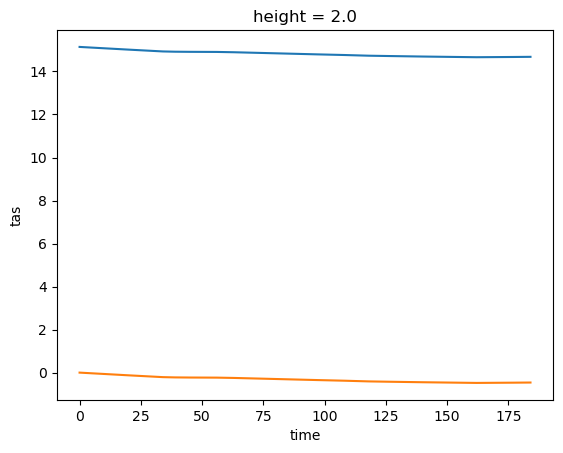

In [67]:
a1_smean_trendfit_lowess_da.plot();
a1_smean_anom_trendfit_lowess_da.plot();

In [68]:
# Generatic variabiles assignment 
# Can swap between filters
a1_smean_anom_trendfit_da = a1_smean_anom_trendfit_lowess_da #a1_smean_anom_trendfit_poly_da
a1_smean_anom_detrend_da = a1_smean_anom_detrend_lowess_da #a1_smean_anom_detrend_poly_da
a1_smean_trendfit_da = a1_smean_trendfit_lowess_da

In [69]:
a1_smean_anom_detrend_da

<xarray.DataArray 'tas' (time: 185)> Size: 1kB
14.98 15.06 15.14 15.04 15.27 15.14 ... 15.32 15.37 15.12 15.02 15.12 15.23
Coordinates:
    height   float64 8B 2.0
  * time     (time) int64 1kB 0 1 2 3 4 5 6 7 ... 178 179 180 181 182 183 184

In [70]:
# Calculating the anomalies
a1_smean_anom_da = a1_smean_da - a1_smean_trendfit_da.isel(time=0)

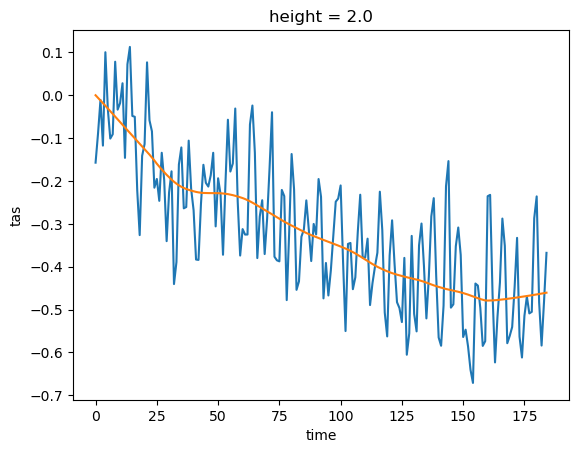

In [71]:
a1_smean_anom_da.plot();
a1_smean_anom_trendfit_da.plot();

## Single window checks S/N Ratio

In [73]:
signal_rolling_da, noise_rolling_da, sn_ratio_test_rolling = sn_calc.signal_to_noise_ratio(
    a1_smean_anom_da, 30, detrended_data=a1_smean_anom_detrend_da, 
    noise_type='rolling', logginglevel='INFO', return_all=True)

- Calculating the rolling signal with method gradient
- noise_type='rolling'
- Calculting the rolling noise


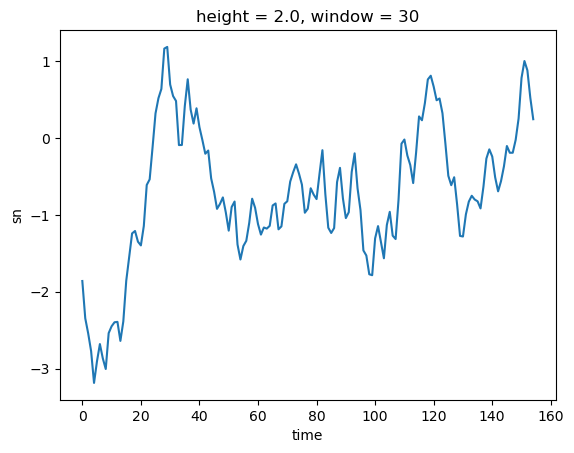

In [74]:
sn_ratio_test_rolling.plot()

## S/N Ratio Calculation

In [75]:
time_length = len(a1_smean_anom_da.dropna(dim='time').time.values)
max_window = int(np.ceil((time_length)/2.5))
# model_window_information[model] = {'time_length':time_length, 'max_window':max_window}

In [76]:
# windows = np.arange(10, max_window, 1)
windows = np.arange(10, max_window)
#np.arange(**constants.ZECMIP_MULTI_WINDOW_PARAMS)
windows

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73])

In [77]:
# Params to use for both
SN_PARAMS = dict(return_all=True, center=True, return_control=True, logginglevel='ERROR')

In [78]:
SN_RATIO_KWARGS = dict(parallel=True,logginglevel='ERROR')

In [79]:
# # Calculate the S/R ratio for the A1 experiment. This noise should be the detrended data
signal_multi_rolling_da = sn_calc.multi_window_func(
    sn_calc.rolling_signal,
    a1_smean_anom_da,
    windows,
    start_align=False,
    **SN_RATIO_KWARGS
)

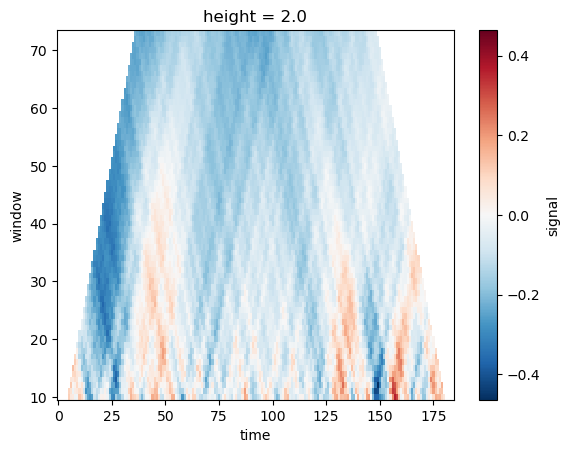

In [80]:
signal_multi_rolling_da.plot(y='window')

In [81]:
# # Calculate the S/R ratio for the A1 experiment. This noise should be the detrended data
noise_multi_rolling_da = sn_calc.multi_window_func(
    sn_calc.rolling_noise, a1_smean_anom_da, windows, start_align=False,
    **SN_RATIO_KWARGS
)

In [82]:
# # Calculate the S/R ratio for the A1 experiment. This noise should be the detrended data
sn_multi_rolling_da = sn_calc.signal_to_noise_ratio_multi_window(
    a1_smean_anom_da, windows,
    detrended_data=a1_smean_anom_detrend_da,
    start_align=False,
    noise_type='rolling',
    # min_periods='half',
    **SN_RATIO_KWARGS
)

In [83]:
sn_multi_rolling_control_da = sn_calc.signal_to_noise_ratio_multi_window(
    esmpi_smean_da, windows, noise_type='rolling', start_align=False, **SN_RATIO_KWARGS
)

sn_multi_rolling_control_da.name = 'signal_to_noise'

In [84]:
# The bounds from the pi-controls
rolling_bounds = sn_calc.upper_and_lower_bounds(sn_multi_rolling_control_da, 1, 99)


In [85]:
# Mergine togeth with the bounds (more of a legacy need)
# Drop nan here, or some windows can be longer than others
sn_multi_rolling_da = xr.merge([sn_multi_rolling_da.to_dataset(), rolling_bounds])

In [86]:
sn_multi_rolling_da

<xarray.Dataset> Size: 98kB
Dimensions:      (time: 185, window: 64)
Coordinates:
    height       float64 8B 2.0
  * time         (time) int64 1kB 0 1 2 3 4 5 6 ... 178 179 180 181 182 183 184
  * window       (window) int64 512B 10 11 12 13 14 15 16 ... 68 69 70 71 72 73
Data variables:
    sn           (window, time) float64 95kB nan nan nan nan ... nan nan nan nan
    lower_bound  (window) float64 512B -2.815 -2.772 -2.756 ... -1.768 -1.754
    upper_bound  (window) float64 512B 2.984 2.944 2.804 ... 2.143 2.112 2.121

In [87]:
# Just the unstalgbe points - both ds and ds
above_or_below_kwargs = dict(main_var='sn', greater_than_var='upper_bound', less_than_var='lower_bound')

unstable_rolling_da = sn_multi_rolling_da.utils.above_or_below(**above_or_below_kwargs)

In [88]:
# For each window get the number of years that are stable forn each point in time
# Note, these are nnot used much. 
decreasing_da = xr.where(unstable_rolling_da < 0, 1, 0)
increasing_da = xr.where(unstable_rolling_da > 0, 1, 0)

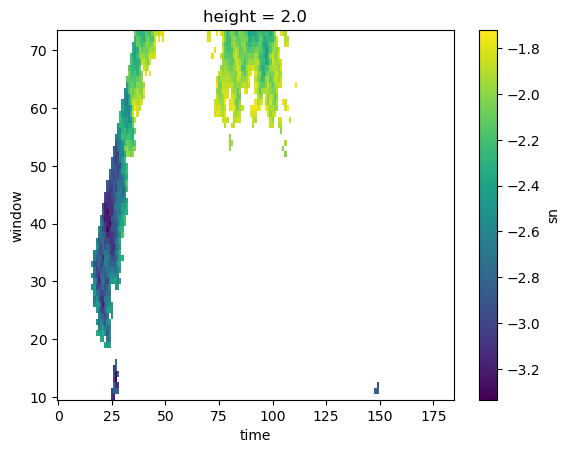

In [89]:
unstable_rolling_da.sn.plot()

# Stabilisation Detection

In [90]:
windows = unstable_rolling_da.window.values
windows

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73])

In [91]:
unstable_rolling_da_model = unstable_rolling_da

model_windows = unstable_rolling_da_model.window.values

unstable_rolling_da_model = xr.where(np.isfinite(unstable_rolling_da_model), 1, 0).sn

max_val = time_length- 11
print(model,model_windows)

MPI-ESM1-2-LR [10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33
 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57
 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73]


In [92]:
unstable_frac_model_da = xr.apply_ufunc(
    sn_calc.frac_non_zero,
    unstable_rolling_da_model, 
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    vectorize=True,
    kwargs = {'period_length': 10}
)

In [93]:
unstable_frac_threshold_model_da = (unstable_frac_model_da>=.5)

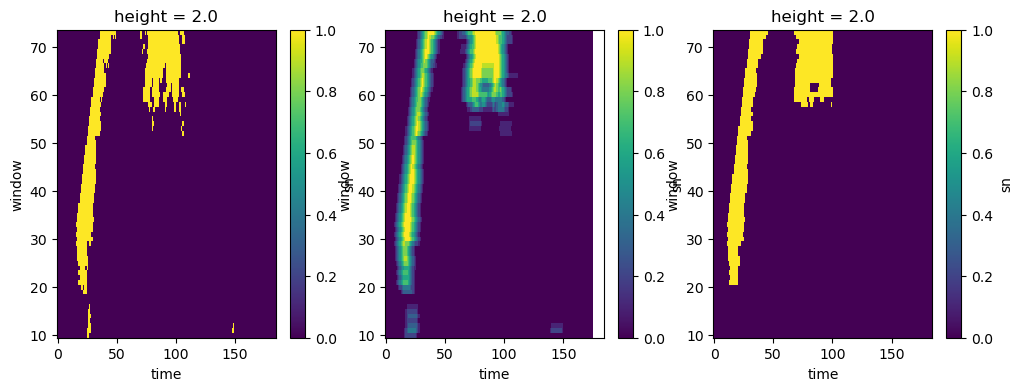

In [94]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12, 4))
unstable_rolling_da_model.plot(y='window', ax=ax1)
unstable_frac_model_da.plot(y='window', ax=ax2)
unstable_frac_threshold_model_da.plot(y='window', ax=ax3)

In [ ]:
# THe number of attempts is an important parameter
# For applying this locally, as the return result must be a grid, the arrays must be padded with 
# nan values at the end.
number_attempts = 4

In [95]:
year_stable_and_unstable_model_ds = xr.apply_ufunc(
    sn_calc.calcuate_year_stable_and_unstable, # This is the function that will perform the calculation
    unstable_rolling_da_model.transpose(*['time', 'window']), # Time must be first
    unstable_frac_threshold_model_da.transpose(*['time', 'window']),
    input_core_dims=[['time', 'window'], ['time', 'window']],
    output_core_dims=[['stability_index']], # A new coordinate called 'stability_index' is return 
    dask_gufunc_kwargs={'output_sizes': {'stability_index': number_attempts}},
    vectorize=True,
    kwargs={'max_val': max_val, 'windows':model_windows, 'period_length': 20,
            'number_attempts':number_attempts, 'logginglevel':'DEBUG'}
)

- period_length=20
- Shapes - time_window_arr = (185, 64), frac_unstable_arr = (185, 64)
- initial_fracs shape (20, 64)
-  - inital_fracs (shape = (20, 64))
[[False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False

In [96]:
# Final result
# New coordinate 'stability_index'
# All odd values (0, 1, 3, 5, ...) are where the models stabilises.
# ALl even values (2, 4, 6, ...) are where the model becomes unstable.
year_stable_and_unstable_model_ds

<xarray.DataArray 'sn' (stability_index: 9)> Size: 72B
51.0 71.0 113.0 nan nan nan nan nan nan
Coordinates:
    height   float64 8B 2.0
Dimensions without coordinates: stability_index

In [98]:
year_stable_and_unstable_model_ds.values

array([ 51.,  71., 113.,  nan,  nan,  nan,  nan,  nan,  nan])

- locator: <matplotlib.ticker.AutoLocator object at 0x14e12d624bb0>


Text(0.5, 1.0, 'MPI-ESM1-2-LR')

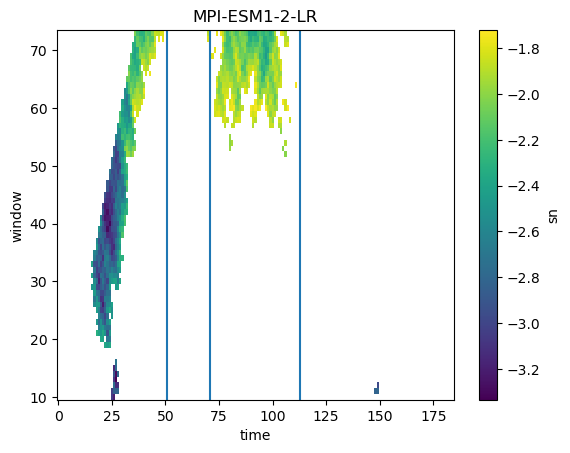

In [102]:
fig, ax = plt.subplots()

# The S/N ratios outsdie of natural variability
unstable_rolling_da.sn.plot(ax=ax)

# Plotn all of the years where a change occurs
years_of_interest = year_stable_and_unstable_model_ds.values
years_of_interest = years_of_interest[np.isfinite(years_of_interest)]
for y in years_of_interest: ax.axvline(y)


ax.set_title(model)